In [71]:
from pyspark.sql import DataFrame, Row, SparkSession
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import albumentations as A
from pyspark.sql.functions import rand, when, col
from functools import reduce
from pyspark.sql.functions import lit


In [72]:
# Variables
# Paramètres de connexion MySQL
db_url = "jdbc:mysql://localhost:3306/wildlens?serverTimezone=UTC"
db_properties = {"user": "root",
                 "password": "root",
                 "driver": "com.mysql.cj.jdbc.Driver"}
mysql_driver_path = "installation/mysql-connector-j-9.1.0.jar"

In [73]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("WildLens ETL - MSPR 24-25") \
    .config("spark.jars", mysql_driver_path) \
    .getOrCreate()

print("✅ Spark initialisé avec le driver MySQL :", mysql_driver_path)
print("🔗 Driver chargé :", spark.sparkContext.getConf().get("spark.jars"))


✅ Spark initialisé avec le driver MySQL : installation/mysql-connector-j-9.1.0.jar
🔗 Driver chargé : installation/mysql-connector-j-9.1.0.jar


In [74]:
try:
    df_tables = spark.read \
        .format("jdbc") \
        .option("url", db_url) \
        .option("dbtable", "information_schema.tables") \
        .option("user", "root") \
        .option("password", "root") \
        .option("driver", "com.mysql.cj.jdbc.Driver") \
        .load()

    df_tables.filter(df_tables["TABLE_SCHEMA"] == "wildlens").select("TABLE_NAME").show()

    print("✅ Connexion à MySQL réussie et tables listées avec succès !")

except Exception as e:
    print(f"❌ Erreur de connexion à MySQL : {e}")


+---------------+
|     TABLE_NAME|
+---------------+
|  wildlens_etat|
| wildlens_facts|
|wildlens_images|
+---------------+

✅ Connexion à MySQL réussie et tables listées avec succès !


# Gestion des métadonnées des espèces

 Dans un premier temps, nous scannons les dossiers disponibles afin d'en faire un dataframe et réutiliser ces informations.
 Puis nous récupérons les métadonnées depuis l'API Mistral grâce à un prompt optimisé (optimisation du grounding, du prompt engineering)
 un sleep de 3s a été ajouté afin d'éviter de trop spam l'API
 -- transféré dans un fichier à part --

In [75]:
folder_all_animals = [d for d in os.listdir("ressource/image/train") if
                      os.path.isdir(os.path.join("ressource/image/train", d))]
df_all_animals = pd.DataFrame(folder_all_animals, columns=["Nom du dossier"])

# Gestion des images
Dans un premier temps, nous allons faire une première analyse des images: leurs nombre par espèces (donc, par dossier), leurs tailles moyenne, leurs poid moyen, etc...

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,105,411.371429,398.304762
1,mouse,129,152.310078,159.891473
2,horse,71,383.521127,340.492958
3,gray_fox,126,278.182540,283.531746
4,goose,141,329.971631,311.737589
5,mink,139,302.273381,293.719424
6,coyote,123,359.276423,405.422764
7,bob_cat,171,250.976608,258.438596
8,skunk,122,442.180328,504.950820
9,black_bear,186,447.930108,421.924731


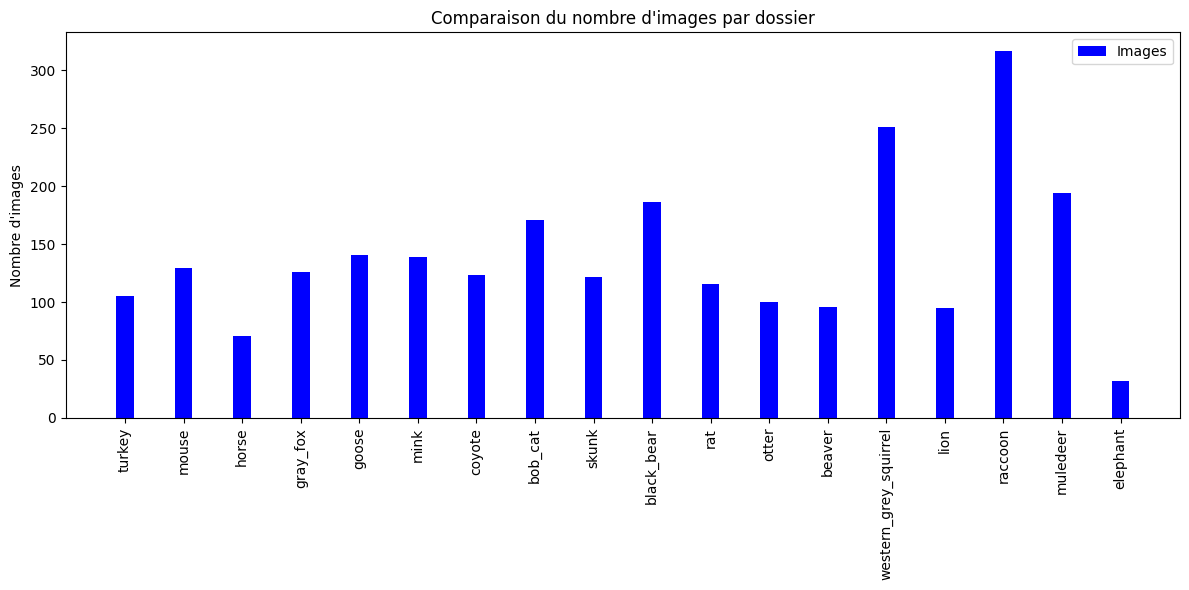

In [76]:
# Définition des chemins des datasets
image = "ressource/image/train"


# Fonction pour récupérer les infos des images d'un dossier (en gérant les dossiers absents)
def get_image_info(folder_path):
    if not os.path.exists(folder_path):  # 📌 Vérifie si le dossier existe
        return 0, None, None  # ⚠️ Si absent → 0 images et tailles nulles

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_images = len(image_files)

    if num_images == 0:
        return num_images, None, None  # Aucun fichier image

    widths, heights = [], []

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Erreur avec l'image {img_file}: {e}")

    avg_width = sum(widths) / len(widths) if widths else None
    avg_height = sum(heights) / len(heights) if heights else None

    return num_images, avg_width, avg_height


# Listes pour stocker les infos
image_data = []

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
df_image = pd.DataFrame(image_data, columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(df_image)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12, 6))

x_labels = df_image["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, df_image["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()



# Augmentation des images
## Data Augmentation et Transformation des Données
La Data Augmentation est une technique utilisée en apprentissage automatique, notamment en vision par ordinateur et en traitement du langage naturel (NLP), pour augmenter la diversité des données d'entraînement sans collecter de nouvelles données. Elle permet de rendre les modèles plus robustes et d'améliorer leur généralisation.

- Calculer la Mediane du nombre des images
- Determiner le Q3 afin que le nombre d'image finale de chaque animale se rapproche
- Calculer le coefficient de multiplication pour chaque classe d'animaux
- Modifier et sauvegarder les nouvelles images
-

In [77]:
# 📂 Définition du chemin des images
image = "ressource/image/train"
augmented_image_folder = "ressource/image/augmented_train"

# 📝 Étape 1 : Calculer la médiane et Q3 du nombre d'images
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

print(f"Médiane: {median_images}, Q3: {q3_images}")


Médiane: 124.5, Q3: 163.5


In [78]:
# Création du dossier de sortie s'il n'existe pas
os.makedirs(augmented_image_folder, exist_ok=True)

# Calcul de la médiane et du Q3 pour équilibrer le dataset
median_images = df_image["Nombre d'images"].median()
q3_images = df_image["Nombre d'images"].quantile(0.75)

# Détermination du coefficient de Data Augmentation
df_image["Coeff"] = np.ceil(q3_images / df_image["Nombre d'images"])

# Définition des transformations sans PyTorch
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.GaussNoise(p=0.1),
    A.Resize(256, 256)  # Redimensionne sans ToTensorV2
])

# Boucle sur chaque classe d’animaux
for index, row in df_image.iterrows():
    if row["Coeff"] < 4:
        folder_name = row["Nom du dossier"]
        coeff = int(row["Coeff"])

        original_folder = os.path.join(image, folder_name)
        augmented_folder = os.path.join(augmented_image_folder, folder_name)
        os.makedirs(augmented_folder, exist_ok=True)

        image_files = [f for f in os.listdir(original_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        for img_file in image_files:
            img_path = os.path.join(original_folder, img_file)
            img = cv2.imread(img_path)  # Lecture avec OpenCV (BGR)

            if img is None:
                print(f"❌ Erreur de lecture de l'image {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Conversion en RGB (évite les problèmes de couleur)

            for i in range(coeff):  # Générer plusieurs images augmentées
                augmented = augmentation(image=img)["image"]
                new_img_path = os.path.join(augmented_folder, f"aug_{i}_{img_file}")
                cv2.imwrite(new_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))  # Sauvegarde avec OpenCV

print("✅ Data Augmentation terminée avec succès !")


✅ Data Augmentation terminée avec succès !


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,210,256.0,256.0
1,mouse,258,256.0,256.0
2,horse,213,256.0,256.0
3,gray_fox,252,256.0,256.0
4,goose,282,256.0,256.0
5,mink,278,256.0,256.0
6,coyote,246,256.0,256.0
7,bob_cat,171,256.0,256.0
8,skunk,244,256.0,256.0
9,black_bear,186,256.0,256.0


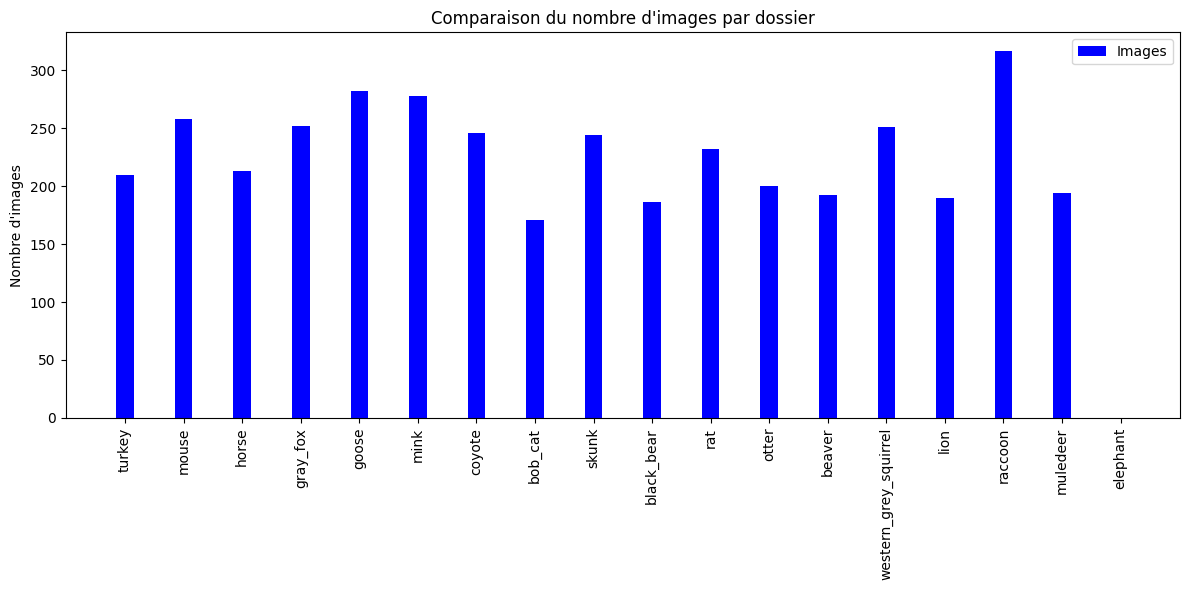

In [79]:
# Listes pour stocker les infos
image_data_new = []
image_new = "ressource/image/augmented_train"

# Parcourir chaque dossier et extraire les infos
for folder in df_all_animals["Nom du dossier"]:
    # ✂️ Images recadrées - entraînement
    folder_path_train = os.path.join(image_new, folder)
    num_images_train, avg_width_train, avg_height_train = get_image_info(folder_path_train)
    image_data_new.append([folder, num_images_train, avg_width_train, avg_height_train])

# Création des DataFrames
image_data_new = pd.DataFrame(image_data_new,
                              columns=["Nom du dossier", "Nombre d'images", "Largeur Moyenne", "Hauteur Moyenne"])

# Affichage du DataFrame de comparaison
display(image_data_new)

# 📊 Visualisation : Comparaison du nombre d'images par dossier
plt.figure(figsize=(12, 6))

x_labels = image_data_new["Nom du dossier"]
x_range = range(len(x_labels))

plt.bar(x_range, image_data_new["Nombre d'images"], width=0.3, label="Images", color='blue')

plt.xticks([x for x in x_range], x_labels, rotation=90)  # Centrage des labels
plt.ylabel("Nombre d'images")
plt.title("Comparaison du nombre d'images par dossier")
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
display(image_data_new)
display(df_image)

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne
0,turkey,210,256.0,256.0
1,mouse,258,256.0,256.0
2,horse,213,256.0,256.0
3,gray_fox,252,256.0,256.0
4,goose,282,256.0,256.0
5,mink,278,256.0,256.0
6,coyote,246,256.0,256.0
7,bob_cat,171,256.0,256.0
8,skunk,244,256.0,256.0
9,black_bear,186,256.0,256.0


,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Coeff
0,turkey,105,411.371429,398.304762,2.0
1,mouse,129,152.310078,159.891473,2.0
2,horse,71,383.521127,340.492958,3.0
3,gray_fox,126,278.182540,283.531746,2.0
4,goose,141,329.971631,311.737589,2.0
5,mink,139,302.273381,293.719424,2.0
6,coyote,123,359.276423,405.422764,2.0
7,bob_cat,171,250.976608,258.438596,1.0
8,skunk,122,442.180328,504.950820,2.0
9,black_bear,186,447.930108,421.924731,1.0


## Labélisation
Le dataframe d'images et les métadata sont fusionnées afin que chaque image corresponde à des métadonnées : c'est la labélisation.

In [81]:
df_metadata = pd.read_csv("./ressource/metadata.csv")

df_merged = pd.merge(image_data_new, df_metadata, left_on='Nom du dossier', right_on='Espèce anglais', how='left')

print(df_merged)
print(df_merged.shape)
print(df_merged.head(10))

df_merged.to_csv("./ressource/data_merged.csv", header=True)

if print(df_merged['Espèce anglais'].isna().sum()):
    print("Toutes les lignes ont trouvés une correspondance")
display(df_merged)

           Nom du dossier  Nombre d'images  Largeur Moyenne  Hauteur Moyenne  \
0                  turkey              210            256.0            256.0   
1                   mouse              258            256.0            256.0   
2                   horse              213            256.0            256.0   
3                gray_fox              252            256.0            256.0   
4                   goose              282            256.0            256.0   
5                    mink              278            256.0            256.0   
6                  coyote              246            256.0            256.0   
7                 bob_cat              171            256.0            256.0   
8                   skunk              244            256.0            256.0   
9              black_bear              186            256.0            256.0   
10                    rat              232            256.0            256.0   
11                  otter              2

,Nom du dossier,Nombre d'images,Largeur Moyenne,Hauteur Moyenne,Espèce anglais,Espèce français,Famille,Nom latin,Description,Population estimée,Localisation
0,turkey,210,256.0,256.0,turkey,Dinde,Phasianidae,Meleagris gallopavo,"Oiseau de grande taille au plumage coloré, ori...",550000000,États-Unis Mexique
1,mouse,258,256.0,256.0,mouse,souris,Muridae,Mus musculus,Petit rongeur avec de grandes oreilles et une ...,600000000,Monde entier
2,horse,213,256.0,256.0,horse,cheval,Equidae,Equus ferus caballus,"Mammifère quadrupède au corps robuste, au cou ...",58000000,France États-Unis Russie Chine
3,gray_fox,252,256.0,256.0,gray_fox,Renard gris,Canidae,Urocyon cinereoargenteus,Le renard gris est un petit canidé aux poils g...,4000000,États-Unis Mexique Canada
4,goose,282,256.0,256.0,goose,oie,Anatidae,Anser anser,L'oie est un grand oiseau aquatique avec un co...,2500000,Canada États-Unis Russie
5,mink,278,256.0,256.0,mink,Vison d'Europe,Mustelidae,Neogale vison,Petit mammifère semi-aquatique avec un pelage ...,1000000,"France, Allemagne, Pologne, Russie"
6,coyote,246,256.0,256.0,coyote,Coyote,Canidae,Canis latrans,"Le coyote est un canidé de taille moyenne, ave...",3000000,États-Unis Canada Mexique
7,bob_cat,171,256.0,256.0,bob_cat,Chat domestique,Felidae,Felis catus,Petit félin domestique au pelage court et aux ...,600000000,France États-Unis Royaume-Uni
8,skunk,244,256.0,256.0,skunk,Putois,Mustelidae,Mephitis mephitis,Le putois est un petit mammifère carnivore con...,3200000,États-Unis Canada
9,black_bear,186,256.0,256.0,black_bear,Ours noir,Ursidae,Ursus americanus,L'ours noir est un ours de taille moyenne avec...,900000,Canada États-Unis Mexique


# State
Ajout d'un state aléatoire sur chaque image.

70% de train (1)

15% de test (2)

15% de val (3)

Ceci servira prochainement pour l'entrainement du model de machine learning


In [82]:
df_merged_spark = spark.createDataFrame(df_merged)
image_new = "ressource/image/augmented_train"

df_dict = {}
for dossier in df_merged_spark.select("Nom du dossier").distinct().rdd.flatMap(lambda x: x).collect():
    folder_path = os.path.join(image_new, dossier)
    if os.path.exists(folder_path):
        df_images = spark.createDataFrame([(dossier, os.path.join(dossier, img)) for img in os.listdir(folder_path)],
                                          ["Nom du dossier", "Chemin Relatif"])
        df_dict[dossier] = df_images.join(df_merged_spark, on="Nom du dossier", how="left")

for dossier, df in df_dict.items():
    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

train_ratio = 0.8
val_ratio = 0.1

for dossier, df in df_dict.items():
    df = df.withColumn("rand_val", rand())

    df = df.withColumn(
        "state",
        when(col("rand_val") <= train_ratio, 1)
        .when(col("rand_val") <= (train_ratio + val_ratio), 2)
        .otherwise(3)
    )

    df_dict[dossier] = df

    df.write.mode("overwrite").parquet(f"ressource/dataframes_parquet/{dossier}")
    df.write.mode("overwrite").csv(f"ressource/dataframes_csv/{dossier}")

    print(f"✅ State ajouté et fichier enregistré pour {dossier}")

if df_dict:
    df_final = reduce(DataFrame.unionAll, df_dict.values())
    print(f" Fusion complète ! Le DataFrame final contient {df_final.count()} images.")
    df_final.write.mode("overwrite").parquet("ressource/dataframes_parquet/all_images")
    df_final.coalesce(1).write.mode("overwrite").csv("ressource/dataframes_csv/all_images", header=True)
else:
    print("⚠️ Aucun DataFrame à fusionner !")



✅ State ajouté et fichier enregistré pour turkey
✅ State ajouté et fichier enregistré pour mouse
✅ State ajouté et fichier enregistré pour horse
✅ State ajouté et fichier enregistré pour gray_fox
✅ State ajouté et fichier enregistré pour goose
✅ State ajouté et fichier enregistré pour mink
✅ State ajouté et fichier enregistré pour coyote
✅ State ajouté et fichier enregistré pour bob_cat
✅ State ajouté et fichier enregistré pour skunk
✅ State ajouté et fichier enregistré pour black_bear
✅ State ajouté et fichier enregistré pour rat
✅ State ajouté et fichier enregistré pour otter
✅ State ajouté et fichier enregistré pour beaver
✅ State ajouté et fichier enregistré pour western_grey_squirrel
✅ State ajouté et fichier enregistré pour lion
✅ State ajouté et fichier enregistré pour raccoon
✅ State ajouté et fichier enregistré pour muledeer


 Fusion complète ! Le DataFrame final contient 3916 images.


root
 |-- Nom du dossier: string (nullable = true)
 |-- Chemin Relatif: string (nullable = true)
 |-- Nombre d'images: long (nullable = true)
 |-- Largeur Moyenne: double (nullable = true)
 |-- Hauteur Moyenne: double (nullable = true)
 |-- Espèce anglais: string (nullable = true)
 |-- Espèce français: string (nullable = true)
 |-- Famille: string (nullable = true)
 |-- Nom latin: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Population estimée: long (nullable = true)
 |-- Localisation: string (nullable = true)
 |-- rand_val: double (nullable = false)
 |-- state: integer (nullable = false)



+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|           rand_val|state|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique|0.17904387666567156|    1|
|        turkey|turkey/aug_0_2442...|            210|          2

Nombre total d'images : 3916
Colonnes : ['Nom du dossier', 'Chemin Relatif', "Nombre d'images", 'Largeur Moyenne', 'Hauteur Moyenne', 'Espèce anglais', 'Espèce français', 'Famille', 'Nom latin', 'Description', 'Population estimée', 'Localisation', 'rand_val', 'state']


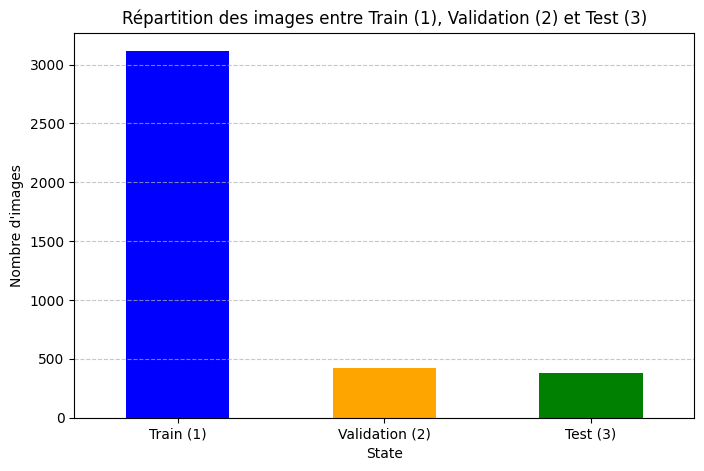

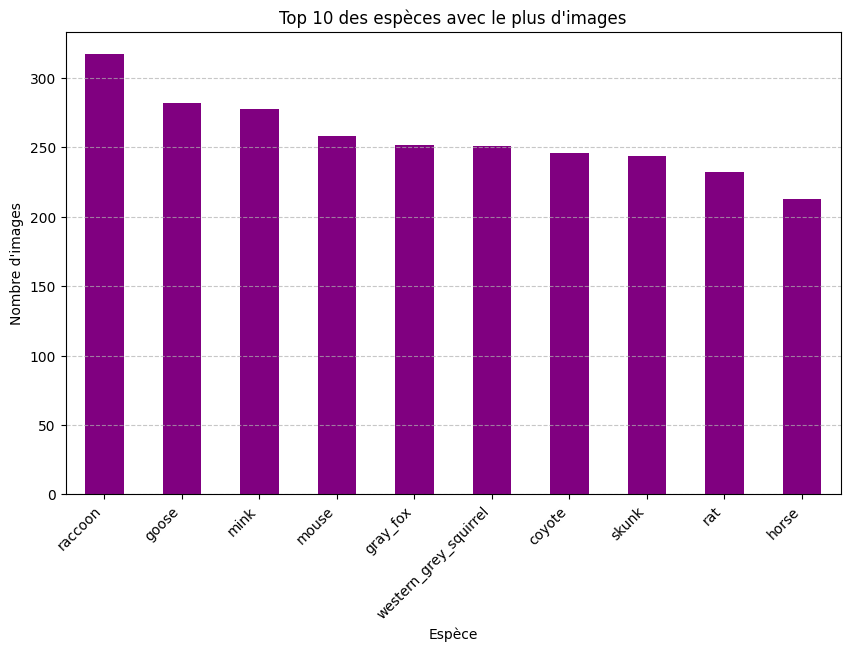

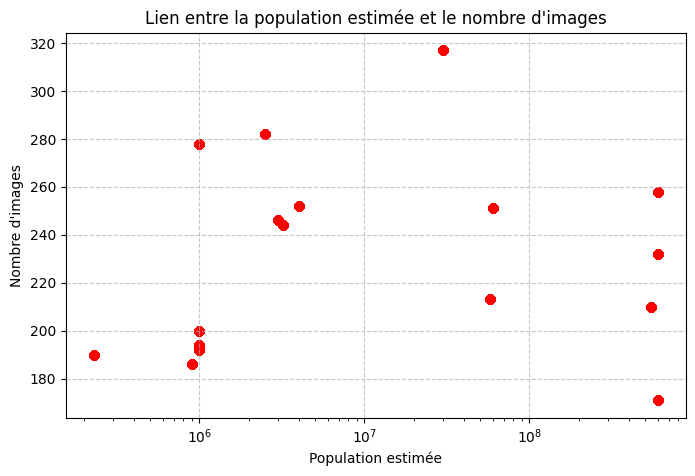

In [83]:
df_final.printSchema()
df_final.show(10)
print(f"Nombre total d'images : {df_final.count()}")
print(f"Colonnes : {df_final.columns}")

df_pandas = df_final.toPandas()

# Compter les occurrences des états (1 = train, 2 = val, 3 = test)
state_counts = df_pandas["state"].value_counts().sort_index()

# 📊 Création du graphique
plt.figure(figsize=(8, 5))
state_counts.plot(kind='bar', color=['blue', 'orange', 'green'])

plt.xlabel("State")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images entre Train (1), Validation (2) et Test (3)")
plt.xticks(ticks=[0, 1, 2], labels=["Train (1)", "Validation (2)", "Test (3)"], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

# Compter le nombre d'images par espèce
species_counts = df_pandas["Espèce anglais"].value_counts().head(10)  # Top 10

# 📊 Création du graphique
plt.figure(figsize=(10, 6))
species_counts.plot(kind='bar', color='purple')

plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.title("Top 10 des espèces avec le plus d'images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_pandas["Population estimée"], df_pandas["Nombre d'images"], alpha=0.5, color='red')

plt.xlabel("Population estimée")
plt.ylabel("Nombre d'images")
plt.title("Lien entre la population estimée et le nombre d'images")
plt.xscale("log")  # Pour une meilleure visibilité
plt.grid(True, linestyle='--', alpha=0.7)

# Afficher le graphique
plt.show()

In [84]:
print("Colonnes de df_facts :", df_final.columns)
print(df_final.describe())

Colonnes de df_facts : ['Nom du dossier', 'Chemin Relatif', "Nombre d'images", 'Largeur Moyenne', 'Hauteur Moyenne', 'Espèce anglais', 'Espèce français', 'Famille', 'Nom latin', 'Description', 'Population estimée', 'Localisation', 'rand_val', 'state']
DataFrame[summary: string, Nom du dossier: string, Chemin Relatif: string, Nombre d'images: string, Largeur Moyenne: string, Hauteur Moyenne: string, Espèce anglais: string, Espèce français: string, Famille: string, Nom latin: string, Description: string, Population estimée: string, Localisation: string, rand_val: string, state: string]


In [85]:
df_existing = spark.read.jdbc(url=db_url, table="wildlens_etat", properties=db_properties)

if df_existing.count() == 0:
    print("La table wildlens_etat est vide, insertion des données...")

    df_etat = spark.createDataFrame([
        Row(id_etat=1, type="train"),
        Row(id_etat=2, type="validation"),
        Row(id_etat=3, type="test")
    ])

    df_etat.write.mode("append").jdbc(url=db_url, table="wildlens_etat", properties=db_properties)

In [86]:
df_existing = spark.read.jdbc(url=db_url, table="wildlens_facts", properties=db_properties)

if df_existing.count() == 0:

    print("La table wildlens_facts est vide, insertion des données...")

    df_facts = df_final.select(
        "Espèce français", "Famille", "Nom latin", "Description", "Population estimée", "Localisation", "Espèce anglais",
        "Nombre d'images"
    ).dropDuplicates()

    df_facts = (df_facts.withColumnRenamed("Espèce anglais", "nom_en")
                .withColumnRenamed("Population estimée", "population_estimee")
                .withColumnRenamed("Nombre d'images", "nombre_image")
                .withColumnRenamed("Espèce français", "nom_fr")
                .withColumnRenamed("Nom latin", "nom_latin"))

    df_facts = df_facts.withColumn("coeff_multiplication", lit(1))

    df_facts.write.jdbc(url=db_url, table="wildlens_facts", mode="append", properties=db_properties)

    print("✅ Table wildlens_facts mise à jour avec succès !")



✅ Table wildlens_facts mise à jour avec succès !


In [88]:
df_existing = spark.read.jdbc(url=db_url, table="wildlens_images", properties=db_properties)

if df_existing.count() == 0:
    print("La table wildlens_images est vide, insertion des données...")

    df_images = spark.read.jdbc(url=db_url, table="wildlens_facts", properties=db_properties)
    df_id_espece = df_images.select("id_espece", "nom_fr").distinct()

    if "id_espece" in df_final.columns:
        df_final = df_final.drop("id_espece")

    # Effectuer la jointure pour récupérer l'ID de l'espèce
    df_final = df_final.join(df_id_espece, df_final["Espèce français"] == df_id_espece["nom_fr"], "left")

    # Supprimer la colonne "nom_fr" après la jointure (elle ne sert plus)
    df_final = df_final.drop("nom_fr")
    print(df_final.show())
    df_facts = df_final.select("Chemin Relatif", "id_espece", "state").dropDuplicates()

    # Vérifier les colonnes après la jointure
    print(df_final.show())

    df_facts = (df_facts.withColumnRenamed("Chemin Relatif", "image")
                .withColumnRenamed("id_espece", "id_espece")
                .withColumnRenamed("state", "id_etat"))

    df_facts.write.jdbc(url=db_url, table="wildlens_images", mode="append", properties=db_properties)

    print("✅ Table wildlens_images mise à jour avec succès !")


+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+---------+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|           rand_val|state|id_espece|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+---------+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique|0.17904387666567156|    1|       35|
|        turkey|turkey/a

+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+---------+
|Nom du dossier|      Chemin Relatif|Nombre d'images|Largeur Moyenne|Hauteur Moyenne|Espèce anglais|Espèce français|    Famille|          Nom latin|         Description|Population estimée|      Localisation|           rand_val|state|id_espece|
+--------------+--------------------+---------------+---------------+---------------+--------------+---------------+-----------+-------------------+--------------------+------------------+------------------+-------------------+-----+---------+
|        turkey|turkey/aug_1_2493...|            210|          256.0|          256.0|        turkey|          Dinde|Phasianidae|Meleagris gallopavo|Oiseau de grande ...|         550000000|États-Unis Mexique|0.17904387666567156|    1|       35|
|        turkey|turkey/a

✅ Table wildlens_images mise à jour avec succès !
